# 모듈

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
from tqdm import tqdm

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsRegressor

# 데이터 호출 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

csv 데이터 호출 

In [6]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

In [ ]:
df

In [7]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 
  
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

Error 데이터 호출 

In [8]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

에러 갯수 = 15.0
이상 갯수 = 15


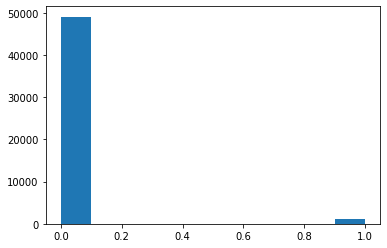

In [9]:
df['error']=0

def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df
  
for index in range(len(error)):
  df = add_error(df,error,index)

#정상적으로 입력 됬는지 확인 
print(f"에러 갯수 = {(len(df[df['error']==1])/69)}")
temp = np.array(error)[:,2:]
print(f'이상 갯수 = {len(temp[temp!=0])}')
plt.hist(df['error'])
plt.show()

# 기본 전처리 

## 편차 계산 
- 기본 세팅값에서 벗어난 정도를 계산 
- 기본 세팅 값은 분포의 평균을 사용 

각 변수의 평균 계산 

In [10]:
columns = ['pH','Temp','Current']
mean_values = np.mean(df[columns],axis=0)
mean_values = dict(mean_values)
print('평균')
print('Ph = ' ,round(mean_values['pH'],2))
print('Temp = ', round(mean_values['Temp'],2))
print('Current = ', round(mean_values['Current'],2))

평균
Ph =  10.27
Temp =  45.02
Current =  7.97


각 변수 별 평균과의 편차 계산 

In [11]:
def diff_cal(columns,values):
  if columns == 'pH':
    return_value = abs(10.27-values)
  if columns == 'Temp':
    return_value = abs(45-values)
  if columns == 'Current' :
    return_value = abs(7.9-values)
  return return_value

df['Current_diff'] = df['Current'].apply(lambda x : diff_cal('Current',x))
df['Temp_diff'] = df['Temp'].apply(lambda x : diff_cal('Temp',x))
df['pH_diff'] = df['pH'].apply(lambda x : diff_cal('pH',x))

df.head()

,Index,Lot,Time,pH,Temp,Current,date,error,Current_diff,Temp_diff,pH_diff
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0,0.56,2.13,0.10
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0,0.36,2.30,0.63
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0,0.56,2.63,0.66
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0,0.14,0.85,0.05
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0,0.67,0.82,0.09


분포 확인

In [12]:
def plot_(column):
  fig, ax1 = plt.subplots()
  ax1.hist(df[df['error']==1][column],alpha=0.5)
  ax2 = ax1.twinx()
  ax2.hist(df[df['error']==0][column],color='r',alpha=0.5)
  plt.title(column)
  plt.legend(['normal'])
  plt.show()

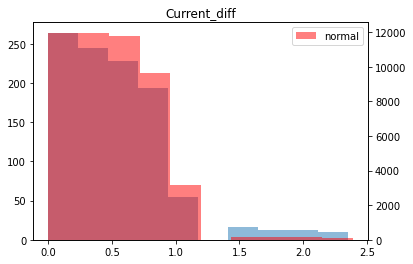

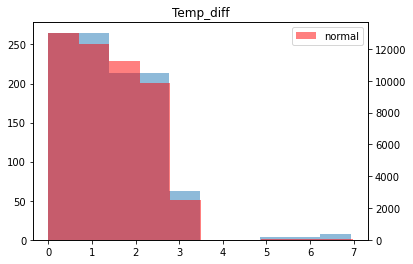

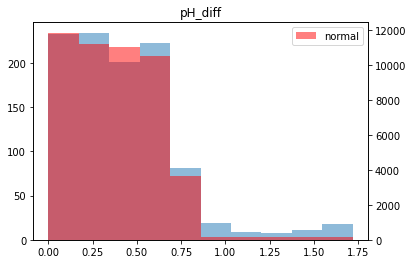

In [13]:
plot_('Current_diff')
plot_('Temp_diff')
plot_('pH_diff')

- 단순히 분포로 보기엔 normal 과 anormal의 차이를 알기 어려움 
- normal - anormal 그리고 각 column 별로 표준 데이터를 만들어 경향을 볼 필요가 있음 

## 표본 데이터 만들기

In [14]:
cycle = list(np.arange(69))*726
cycle = np.array(cycle)
df['cycle'] = cycle

In [15]:
def make_kn(normal,column):
  x = np.array(df[df['error']==normal]['cycle']).reshape(-1,1)
  y = np.array(np.array(df[df['error']==normal][column]).reshape(-1,1))
  kn = KNeighborsRegressor()
  kn.fit(x,y)
  y_ = kn.predict(np.arange(69).reshape(-1,1))
  return y_

표본 데이터

In [16]:
#정상 
y_pH = make_kn(0,'pH')
y_Temp = make_kn(0,'Temp')
y_Current = make_kn(0,'Current')
#비정상
y_pH_anormal = make_kn(1,'pH')
y_Temp_anormal = make_kn(1,'Temp')
y_Current_anormal = make_kn(1,'Current')


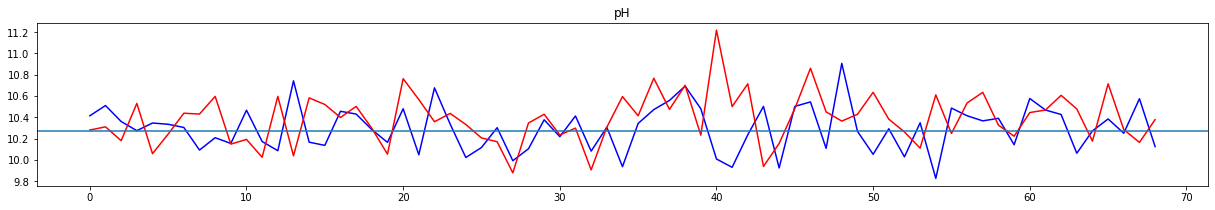

normal_ph_counts = 14
anormal_ph_counts = 20


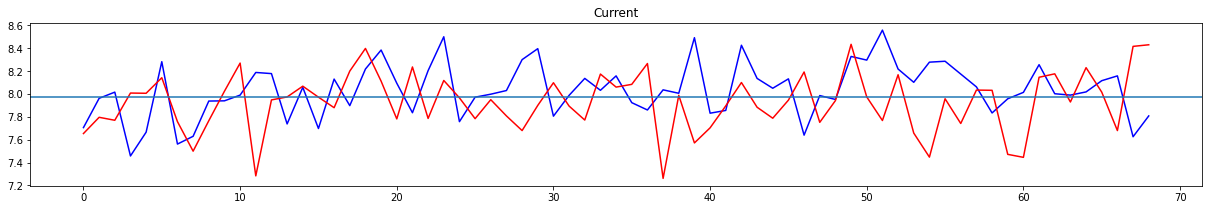

normal_Current_counts = 29
anormal_Current_counts = 31


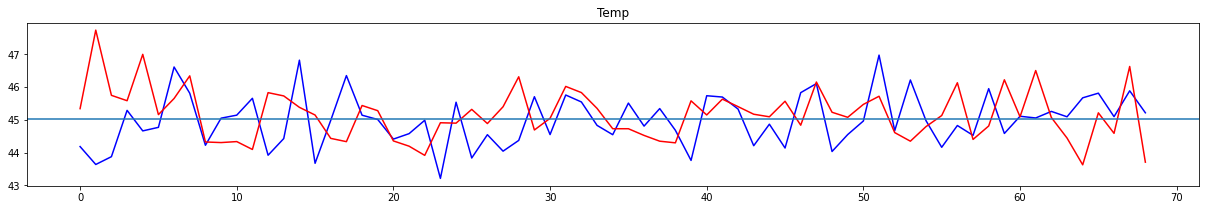

normal_Temp_counts = 11
anormal_Temp_counts = 10


In [17]:
standard = 0.025

plt.figure(figsize=(21,3))
plt.plot(y_pH,color='b')
plt.plot(y_pH_anormal,color='r')
# plt.axhline(mean_values['pH']*(1+standard))
# plt.axhline(mean_values['pH']*(1-standard))
plt.axhline(mean_values['pH'])
plt.title('pH')
plt.show()
normal_counts = len(y_pH[(y_pH>mean_values['pH']*(1+standard)) | (y_pH < mean_values['pH']*(1-standard))])
anormal_counts = len(y_pH_anormal[(y_pH_anormal>mean_values['pH']*(1+standard)) | (y_pH_anormal < mean_values['pH']*(1-standard))])
print(f'normal_ph_counts = {normal_counts}')
print(f'anormal_ph_counts = {anormal_counts}')

plt.figure(figsize=(21,3))
plt.plot(y_Current,color='b')
plt.plot(y_Current_anormal,color='r')
# plt.axhline(mean_values['Current']*(1+standard))
# plt.axhline(mean_values['Current']*(1-standard))
plt.axhline(mean_values['Current'])
plt.title('Current')
plt.show()

normal_counts = len(y_Current[(y_Current>mean_values['Current']*(1+standard)) | (y_Current < mean_values['Current']*(1-standard))])
anormal_counts = len(y_Current_anormal[(y_Current_anormal>mean_values['Current']*(1+standard)) | (y_Current_anormal < mean_values['Current']*(1-standard))])
print(f'normal_Current_counts = {normal_counts}')
print(f'anormal_Current_counts = {anormal_counts}')

plt.figure(figsize=(21,3))
plt.plot(y_Temp,color='b')
plt.plot(y_Temp_anormal,color='r')
# plt.axhline(mean_values['Temp']*(1+standard))
# plt.axhline(mean_values['Temp']*(1-standard))
plt.axhline(mean_values['Temp'])
plt.title('Temp')
plt.show()

normal_counts = len(y_Temp[(y_Temp>mean_values['Temp']*(1+standard)) | (y_Temp < mean_values['Temp']*(1-standard))])
anormal_counts = len(y_Temp_anormal[(y_Temp_anormal>mean_values['Temp']*(1+standard)) | (y_Temp_anormal < mean_values['Temp']*(1-standard))])
print(f'normal_Temp_counts = {normal_counts}')
print(f'anormal_Temp_counts = {anormal_counts}')

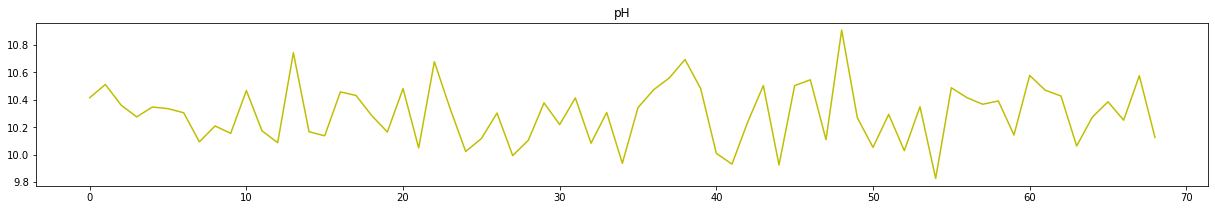

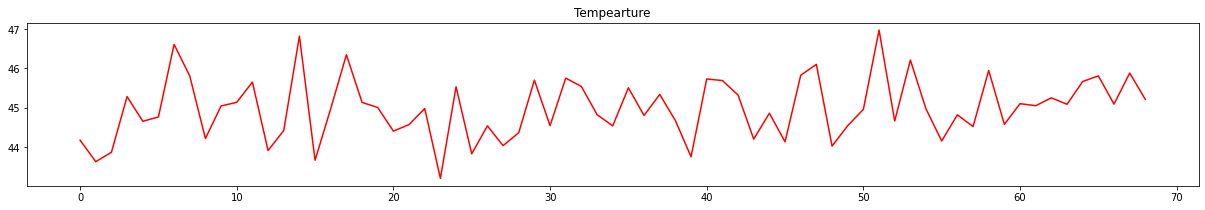

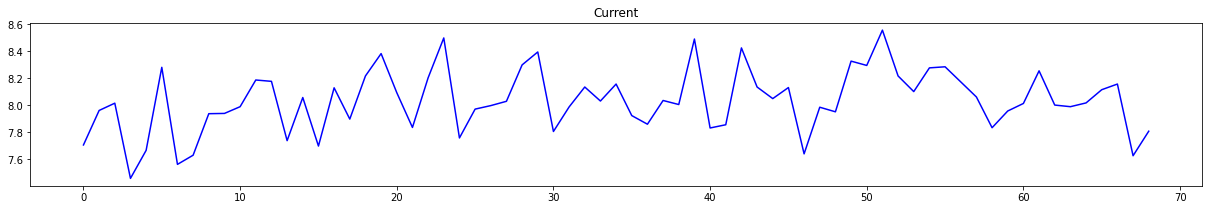

In [18]:
plt.figure(figsize= (21,3))
plt.plot(y_pH,color='y')
plt.title('pH')

plt.figure(figsize= (21,3))
plt.plot(y_Temp,color='r')
plt.title('Tempearture')

plt.figure(figsize= (21,3))
plt.plot(y_Current,color='b')
plt.title('Current')
plt.show()

In [19]:
def column_over(column,value):
  standard_over_value = mean_values[column]*(1+standard)
  standard_under_value = mean_values[column]*(1-standard)
  if value > standard_over_value:
    return 1 
  if value < standard_under_value:
    return 1 

In [20]:
df['pH_over']=0
df['Temp_over']=0
df['Current_over']=0

In [21]:
df['pH_over'] = df['pH'].apply(lambda x: column_over('pH',x))
df['Temp_over'] = df['pH'].apply(lambda x: column_over('Temp',x))
df['Current_over'] = df['pH'].apply(lambda x: column_over('Current',x))

In [22]:
df['Current_over']

0       1
1       1
2       1
3       1
4       1
       ..
1513    1
1514    1
1515    1
1516    1
1517    1
Name: Current_over, Length: 50094, dtype: int64

# EDA

In [23]:
df['date'] = pd.to_datetime(df['date'])

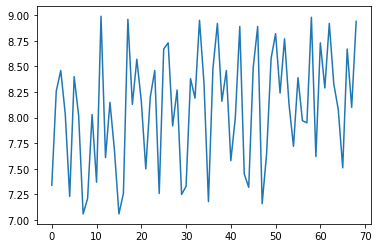

In [24]:
plt.plot(df.loc[(df['date']=='2021-09-06') & (df['Lot']==1)]['Current'])

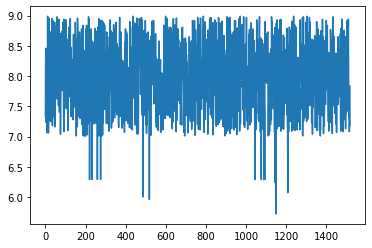

In [25]:
plt.plot(df.loc[df['date']=='2021-09-06']['Current'])

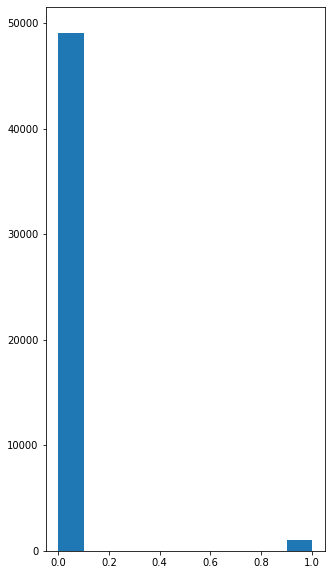

In [40]:
plt.figure(figsize=(5,10))
plt.hist(df['error'])
plt.show()

# 모델링 전처리

## 컬럼 제거 

In [145]:
cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','error']
input = df[cols]

## 스케일링

In [146]:
max = np.max(input.iloc[:,:-1],axis=0)
min = np.min(input.iloc[:,:-1],axis=0)

In [147]:
for col in input.columns[:-1]:
  input[col] = input[col].apply(lambda x : (x-min[col])/(max[col]-min[col]))
input = np.array(input)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 시계열 분할

In [148]:
input = input.reshape(-1,69,7)  
input.shape

(726, 69, 7)

In [149]:
output = np.zeros(726)
for index in range(726):
  temp = input[index]
  if temp[:,6].sum()==69:
    output[index]=1

## Train-valid-test 분할

In [ ]:
input = input[:,:,:-1].reshape(-1,69*6)
input.shape

train_x = input[:400,]
train_y = output[:400,]

valid_x = input[400:570,]
valid_y = output[400:570,]

test_x = input[570:,]
test_y = output[570:,]

# 모델

In [33]:
def check_recall(predicted,valid_y,estimator,feat,cont):
  result = np.where(valid_y==1)[0]
  result
  n = 0 
  target = []
  for i in predicted:
    if i in result:
      n+=1
      target.append(i)
    else:
      pass
  if n!=0 :
    recall = n/len(result) #정답 중 맞춘 비율 (예측 정답 / 정답 갯수)  
    precision = n/len(predicted) #예측 중 정답 비율 (예측 정답 / 예측 갯수)
    f1score = (recall*precision)/(recall+precision)*2
    if f1score >=0.3:
      print('-------')
      print(f'predicted ={len(predicted)}')
      print(f'recall = {recall}')
      print(f'precision = {precision}')
      print(f'f1score = {f1score}')
      print(f'n_estimators = {estimator}')
      print(f'max_features = {feat}')
      print(f'cont = {cont}')
      print(target,n)
      print('-------')
      return f1score
  else:
    pass

In [34]:
from tqdm import tqdm

In [ ]:
# for i in [120]:
for estimator in [100,110,120,130,140,150,160,170,180,190,200]:
  for feat in np.arange(1,40,1):
    for cont in np.arange(0.01,0.5,0.01):
      IF = IsolationForest(n_estimators=estimator,contamination = cont,max_features=feat)
      IF.fit(train_x)
      y_ = IF.predict(valid_x)
      predicted = np.where(y_==-1)[0]
      a = check_recall(predicted,valid_y,estimator,feat,cont)
    

In [170]:
estimator = 150
feat = 8
cont = 0.01
while(True):
  IF3 = IsolationForest(n_estimators=estimator,contamination = cont,max_features=feat,)
  IF3.fit(train_x)
  y_ = IF3.predict(valid_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,valid_y,estimator,feat,cont)
  a = check_recall(predicted,valid_y,estimator,feat,cont)
  try:
    if a >= 0.6:
      break
  except:
    pass

-------
predicted =4
recall = 0.6666666666666666
precision = 0.5
f1score = 0.5714285714285715
n_estimators = 150
max_features = 8
cont = 0.01
[14, 154] 2
-------
-------
predicted =4
recall = 0.6666666666666666
precision = 0.5
f1score = 0.5714285714285715
n_estimators = 150
max_features = 8
cont = 0.01
[14, 154] 2
-------
-------
predicted =3
recall = 0.3333333333333333
precision = 0.3333333333333333
f1score = 0.3333333333333333
n_estimators = 150
max_features = 8
cont = 0.01
[14] 1
-------
-------
predicted =3
recall = 0.3333333333333333
precision = 0.3333333333333333
f1score = 0.3333333333333333
n_estimators = 150
max_features = 8
cont = 0.01
[14] 1
-------
-------
predicted =4
recall = 0.6666666666666666
precision = 0.5
f1score = 0.5714285714285715
n_estimators = 150
max_features = 8
cont = 0.01
[14, 154] 2
-------
-------
predicted =4
recall = 0.6666666666666666
precision = 0.5
f1score = 0.5714285714285715
n_estimators = 150
max_features = 8
cont = 0.01
[14, 154] 2
-------
-------


#예측

metric = f1score

In [169]:
y_ = IF3.predict(valid_x)
predicted = np.where(y_==-1)[0]
a = check_recall(predicted,test_y,estimator,feat,cont)
print(a)

None


In [171]:
y_ = IF3.predict(valid_x)

In [172]:
y_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [157]:
train_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [173]:
y_ = abs(y_-1)/2

In [175]:
from sklearn.metrics import classification_report

print(classification_report(valid_y,y_,target_names =['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       167
           1       0.67      0.67      0.67         3

    accuracy                           0.99       170
   macro avg       0.83      0.83      0.83       170
weighted avg       0.99      0.99      0.99       170



In [133]:
input = df.drop(columns = ['date','Time','Lot','pH_over','Temp_over','Current_over'])
input = np.array(input)

In [138]:
x_train = input[:400*69,:6]
x_valid = input[400*69:570*69,:6]
x_test = input[570*69,:6]

y_train = input[:400*69,-1]
y_valid = input[400*69:570*69,-1]
y_test = input[570*69,-1]

In [ ]:
# for i in [120]:
for estimator in [100,110,120,130,140,150,160,170,180,190,200]:
  for feat in np.arange(1,6,1):
    for cont in np.arange(0.01,0.5,0.01):
      IF = IsolationForest(n_estimators=estimator,contamination = cont,max_features=feat)
      IF.fit(x_train)
      y_ = IF.predict(x_valid)
      predicted = np.where(y_==-1)[0]
      a = check_recall(predicted,valid_y,estimator,feat,cont)
    

metric = precision

In [ ]:
y_ = IF3.predict(valid_x)
predicted = np.where(y_==-1)[0]
a = check_recall(predicted,valid_y,estimator,feat,cont)
print(a)

In [ ]:
y_ = IF.predict(test_x)
predicted = np.where(y_==-1)[0]
predicted

In [59]:
y_ = IF3.predict(valid_x)
y_score = IF3.score_samples(valid_x)

In [60]:
y_anormal_score = y_score[np.where(y_==-1)]
y_normal_score = y_score[np.where(y_==1)]

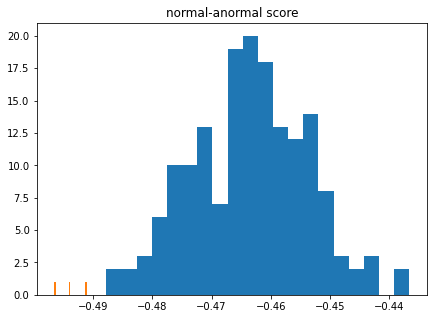

In [62]:
plt.figure(figsize=(7,5))
plt.hist(y_normal_score,bins=20)
plt.hist(y_anormal_score,bins=20)
# plt.axvline(y_anormal_score[0],color='r')
# plt.axvline(y_anormal_score[1],color='r')
plt.title('normal-anormal score')
plt.show()

In [ ]:
y_anormal_score

In [68]:
df.drop(columns = ['cycle','Index'])

,Lot,Time,pH,Temp,Current,date,error,Current_diff,Temp_diff,pH_diff,pH_over,Temp_over,Current_over
0,1,오후 4:29:15.0,10.37,42.87,7.34,2021-09-06,0,0.56,2.13,0.10,NaN,1,1
1,1,오후 4:29:20.0,10.90,42.70,8.26,2021-09-06,0,0.36,2.30,0.63,1.0,1,1
2,1,오후 4:29:25.0,9.61,42.37,8.46,2021-09-06,0,0.56,2.63,0.66,1.0,1,1
3,1,오후 4:29:30.0,10.32,45.85,8.04,2021-09-06,0,0.14,0.85,0.05,NaN,1,1
4,1,오후 4:29:35.0,10.36,44.18,7.23,2021-09-06,0,0.67,0.82,0.09,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,22,오후 6:39:05.9,9.79,43.52,8.55,2021-10-27,0,0.65,1.48,0.48,1.0,1,1
1514,22,오후 6:39:10.9,9.53,44.44,7.36,2021-10-27,0,0.54,0.56,0.74,1.0,1,1
1515,22,오후 6:39:15.9,9.86,46.54,8.15,2021-10-27,0,0.25,1.54,0.41,1.0,1,1
1516,22,오후 6:39:20.9,10.52,47.88,7.97,2021-10-27,0,0.07,2.88,0.25,NaN,1,1


In [76]:
col = ['date','Time','Lot','pH','Temp','Current','pH_diff','Temp_diff','Current_diff','pH_over','Temp_over','Current_over','error']

In [92]:
df[df['error']==1]

,date,Time,Lot,pH,Temp,Current,pH_diff,Temp_diff,Current_diff,pH_over,Temp_over,Current_over,error
828,2021-09-07,오후 5:34:03.2,13,9.65,50.42,7.97,0.62,5.42,0.07,1.0,0,0,1
829,2021-09-07,오후 5:34:08.2,13,9.88,45.15,7.25,0.39,0.15,0.65,1.0,0,0,1
830,2021-09-07,오후 5:34:13.2,13,10.33,47.89,8.40,0.06,2.89,0.50,0.0,0,0,1
831,2021-09-07,오후 5:34:18.2,13,10.77,45.04,8.41,0.50,0.04,0.51,1.0,0,0,1
832,2021-09-07,오후 5:34:23.2,13,9.90,47.05,7.37,0.37,2.05,0.53,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,2021-10-26,오후 5:53:34.7,15,10.95,43.65,7.05,0.68,1.35,0.85,1.0,0,0,1
1031,2021-10-26,오후 5:53:39.7,15,9.71,45.72,7.14,0.56,0.72,0.76,1.0,0,0,1
1032,2021-10-26,오후 5:53:44.7,15,9.92,47.64,8.95,0.35,2.64,1.05,1.0,0,0,1
1033,2021-10-26,오후 5:53:49.7,15,9.73,42.80,8.47,0.54,2.20,0.57,1.0,0,0,1


In [109]:
df[df['date']=='2021-09-07'].iloc[830:]

,date,Time,Lot,pH,Temp,Current,pH_diff,Temp_diff,Current_diff,pH_over,Temp_over,Current_over,error
830,2021-09-07,오후 5:34:13.2,13,10.33,47.89,8.40,0.06,2.89,0.50,0.0,0,0,1
831,2021-09-07,오후 5:34:18.2,13,10.77,45.04,8.41,0.50,0.04,0.51,1.0,0,0,1
832,2021-09-07,오후 5:34:23.2,13,9.90,47.05,7.37,0.37,2.05,0.53,1.0,0,0,1
833,2021-09-07,오후 5:34:28.2,13,10.77,45.11,7.86,0.50,0.11,0.04,1.0,0,0,1
834,2021-09-07,오후 5:34:33.2,13,10.34,47.19,7.72,0.07,2.19,0.18,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,2021-09-07,오후 6:34:29.6,22,11.86,45.58,7.25,1.59,0.58,0.65,1.0,0,0,0
1514,2021-09-07,오후 6:34:34.6,22,10.59,42.43,8.39,0.32,2.57,0.49,1.0,0,0,0
1515,2021-09-07,오후 6:34:39.6,22,10.33,47.29,8.73,0.06,2.29,0.83,0.0,0,0,0
1516,2021-09-07,오후 6:34:44.6,22,10.91,42.20,7.55,0.64,2.80,0.35,1.0,0,0,0


In [116]:
def Temp_over(value):
  if value > 49:
    return 1
  else:
    return 0

def pH_over(value):
  if value > 11:
    return 1
  else:
    return 0

def Current_over(value):
  if value < 6.6:
    return 1
  else:
    return 0

In [ ]:
df['Temp_over'] = df['Temp'].map(Temp_over)
df['pH_over'] = df['pH'].map(pH_over)
df['Current_over'] = df['Current'].map(Current_over)

In [119]:
df[df['date']=='2021-09-07'].iloc[830:]

,date,Time,Lot,pH,Temp,Current,pH_diff,Temp_diff,Current_diff,pH_over,Temp_over,Current_over,error
830,2021-09-07,오후 5:34:13.2,13,10.33,47.89,8.40,0.06,2.89,0.50,0,0,0,1
831,2021-09-07,오후 5:34:18.2,13,10.77,45.04,8.41,0.50,0.04,0.51,0,0,0,1
832,2021-09-07,오후 5:34:23.2,13,9.90,47.05,7.37,0.37,2.05,0.53,0,0,0,1
833,2021-09-07,오후 5:34:28.2,13,10.77,45.11,7.86,0.50,0.11,0.04,0,0,0,1
834,2021-09-07,오후 5:34:33.2,13,10.34,47.19,7.72,0.07,2.19,0.18,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,2021-09-07,오후 6:34:29.6,22,11.86,45.58,7.25,1.59,0.58,0.65,1,0,0,0
1514,2021-09-07,오후 6:34:34.6,22,10.59,42.43,8.39,0.32,2.57,0.49,0,0,0,0
1515,2021-09-07,오후 6:34:39.6,22,10.33,47.29,8.73,0.06,2.29,0.83,0,0,0,0
1516,2021-09-07,오후 6:34:44.6,22,10.91,42.20,7.55,0.64,2.80,0.35,0,0,0,0
